<a href="https://colab.research.google.com/github/MatiTaila/hack_iia/blob/ia-2003/image_clasification/Clasificacion%20de%20imagenes%20con%20kNN%20-%20SOLUCION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de imágenes con kNN

En este ejercicio retomaremos el algoritmo de kNN visto en la clase anterior, pero esta vez aplicado a un caso real, de clasificación de imágenes.


## Configuración
Montaremos el drive y luego apuntaremos al directorio correcto par descargar un dataset de imágenes, utilizando el script `get_datasets.sh`

## Dataset

El dataset se compone de 60.000 imágenes de 32x32 clasificadas en 10 categorías

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os
os.chdir('/content/drive/My Drive/hack_iia/image_clasification/')  #change dir
!pwd

In [0]:
%%shell
. get_datasets.sh

## Implementación del clasificador
Primero, importamos las librerías necesarias

In [2]:
from __future__ import print_function

import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Luego cargamos los datos

In [3]:
cifar10_dir = 'cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Y visualizamos algunos ejemplos

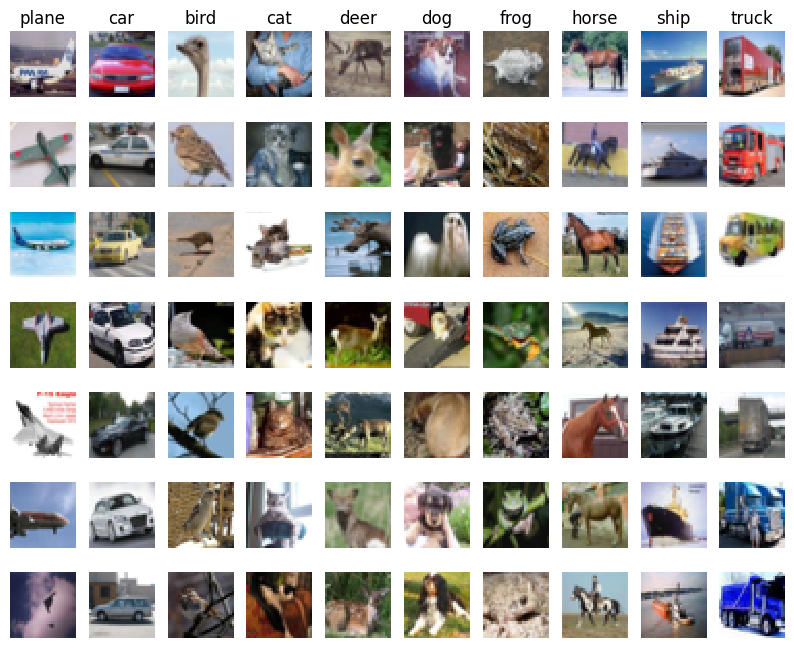

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Aquí simplemente vamos a submuestrear nuestro dataset para quedarnos con menos datos y hacer el ejercicio más ágil.

In [5]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

Ahora vamos a cambiarle la forma a las imágenes. 
Las tenemos en 3D, de la forma `[ancho] x [alto] x [canales]`, pero las necesitamos como un vector de `[1] x [ancho x alto x canales]`


In [6]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print (X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


## Implementación de kNN 
Aquí presentamos una implementación eficiente de kNN.
Creamos una clase con los métodos necesarios.

In [7]:
class KNearestNeighbor(object):

  def __init__(self):
    pass

  def train(self, X, y):
    self.X_train = X
    self.y_train = y
    
  def predict(self, X, k=1):
    dists = self.compute_distances(X)
    return self.predict_labels(dists, k=k)

  def compute_distances(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    test_sum_square = np.sum(np.square(X), axis=1)
    train_sum_square = np.sum(np.square(self.X_train), axis=1)
    dists = np.sqrt(np.tile(test_sum_square, (num_train, 1)).T + np.tile(train_sum_square, (num_test, 1)) - 2 * np.dot(X, self.X_train.T))
    return dists

  def predict_labels(self, dists, k=1):
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)

    for i in range(num_test):
      closest_y = []
      closest_y = self.y_train[np.argsort(dists[i, :])[:k]]
      y_pred[i] = np.bincount(closest_y).argmax()
    return y_pred

## Entrenamiento 

Ahora que tenemos la clase creada y los datos ordenados, el entrenamiento es muy sencillo:

In [8]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
dists = classifier.compute_distances(X_test)
print(dists.shape)

(500, 5000)


A continuación se presenta una forma de visualizar las distancias entre cada punto de test y cada punto de entrenamiento.

Los valoes más claros significan distancias más grandes, mientras los valores más oscuros distancias menores.

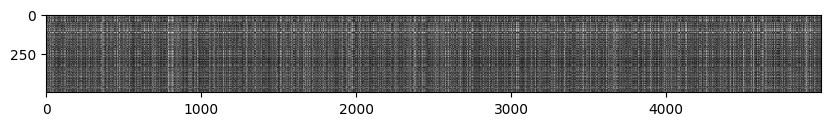

In [9]:
plt.imshow(dists, interpolation='none')
plt.show()

Nota: lo único que se está comparando es el valor de los píxeles de cada imagen. Por lo tanto, un valor muy blanco en la posición [i,j] de la representación anterior implica que los píxeles de las imágenes [i] y [j] son muy distintos. Por ello, si toda una fila presenta valores muy "blancos" (en esta representación), quiere decir que la imágen de test [i] es muy distinta a todas las de entrenamiento. Análogamente una columna [j] muy blanca nos dice que la imágen [j] de entrenamiento es muy distinta a todas las de test. "Distinta" en este caso refiere solamente a los valores de los píxeles.

## Precicción

Ahora simplemente ejecutamos la predicción y calculamos nuestra performance

In [10]:
y_test_pred = classifier.predict_labels(dists, k=5)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Obtuvimos %d / %d correctas => Precisión: %f' % (num_correct, num_test, accuracy))

Obtuvimos 139 / 500 correctas => Precisión: 0.278000


## ¡FIN!